## Astoria  conquest

I've been living in Astoria for the past 2 years. I usually run around the roosvelt Island that's not far away from my house. One day I was exploring the area and I found out that there are a lot of good places to know in here. So, that's why I decided to run all astoria 10 miles at the time.

This project is simple but not easy: I want to run all the street of astoria, starting from my house and finishing at the gym since I like to do sauna after running.

First, we needed to know what are the boundaries of this challenge for that we went to the NYC database and collect the data from the neighborhood tabulation, NTAS LINK (https://data.cityofnewyork.us/City-Government/2020-Neighborhood-Tabulation-Areas-NTAs-/9nt8-h7nd/about_data)

second,  of all, we will use Strava to record all my runs, so every time I run this one will be uploaded to the file that way I will see how many miles I have left to run

Challenges:
The main challenge is the optimization of this project since I want to run at least 8 miles each time, but also I want to do it in the list runs as possible therefore we have a optimization of routes. 

So in real time requires the API from Strava and also I want to connect with my wo whoop data that way we have un holistic view of what happened in my runnings since I want to know what are the main factors for me to have a good run meaning a good pace and a stable pace.



## 1. Data loading and first exploration

In [1]:
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
CSV_PATH = "/Users/camilo/camilomartinez-portfolio/backend/lab/astoria_routes/2020_Neighborhood_Tabulation_Areas__NTAs__20250831.csv"
data = pd.read_csv(CSV_PATH)
# Display the column names of the DataFrame
data.dtypes
data.head(2)

,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Length,Shape_Area,the_geom
0,4,Queens,81,QN0101,Astoria (North)-Ditmars-Steinway,Astr_N,0,QN01,QN01 Astoria-Queensbridge (CD 1 Equivalent),45685.63975,58301781.05,MULTIPOLYGON (((-73.88945486837545 40.77353295...
1,4,Queens,81,QN0102,Old Astoria-Hallets Point,OldAstr,0,QN01,QN01 Astoria-Queensbridge (CD 1 Equivalent),15102.26240,11091067.00,MULTIPOLYGON (((-73.92827730832717 40.77689897...


In [2]:
%pip install geopandas shapely matplotlib pandas centerline 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


🔄 Loading and cleaning CSV data...
   • Total rows: 8
   • Checking geometry column...
   • Rows with empty/null geometry: 0
🔄 Parsing WKT geometries...
   • Warning: Failed to parse geometry: ParseException: Expected word but encountered end of stream...
   • Removing 1 rows with failed geometry parsing...
✅ Successfully parsed 7 geometries
🔄 Filtering for Astoria neighborhoods...
   • Available neighborhoods: ['Astoria (Central)', 'Astoria (East)-Woodside (North)', 'Astoria Park', 'Old Astoria-Hallets Point', 'Queensbridge-Ravenswood-Dutch Kills', "St. Michael's Cemetery", 'Sunnyside Yards (North)']
✅ Found 3 Astoria neighborhoods


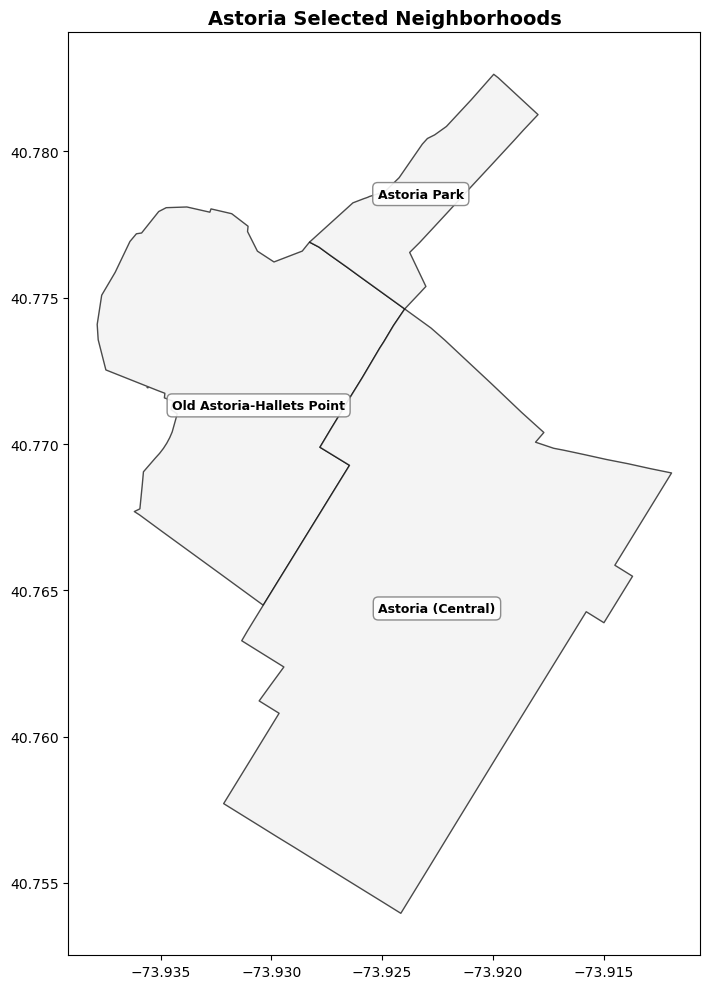

📊 Summary:
   • Neighborhoods included: ['Old Astoria-Hallets Point', 'Astoria (Central)', 'Astoria Park']
   • Total area covered: 0.000345 square degrees


/var/folders/l6/7c34hv4d1qxf6512mr1v27cc0000gn/T/ipykernel_18497/2184614003.py:98: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"   • Total area covered: {gdf_astoria.geometry.area.sum():.6f} square degrees")


In [3]:
# Fixed geometry loading with error handling
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

CSV_PATH = "/Users/camilo/camilomartinez-portfolio/backend/lab/astoria_routes/2020_Neighborhood_Tabulation_Areas__NTAs__20250831.csv"

print("🔄 Loading and cleaning CSV data...")
data = pd.read_csv(CSV_PATH)

# First, let's check for any issues with the geometry column
print(f"   • Total rows: {len(data)}")
print(f"   • Checking geometry column...")

# Check for empty or null geometry values
empty_geom = data['the_geom'].isnull() | (data['the_geom'] == '') | (data['the_geom'].str.strip() == '')
print(f"   • Rows with empty/null geometry: {empty_geom.sum()}")

if empty_geom.sum() > 0:
    print("   • Removing rows with invalid geometry...")
    data = data[~empty_geom].copy()
    print(f"   • Remaining rows: {len(data)}")

# Safe WKT parsing with error handling
def safe_wkt_load(wkt_string):
    """Safely load WKT geometry with error handling"""
    try:
        if pd.isna(wkt_string) or wkt_string.strip() == '':
            return None
        return wkt.loads(wkt_string)
    except Exception as e:
        print(f"   • Warning: Failed to parse geometry: {str(e)[:100]}...")
        return None

print("🔄 Parsing WKT geometries...")
wkt_series = data['the_geom'].apply(safe_wkt_load)

# Remove any rows where geometry parsing failed
valid_geom = wkt_series.notna()
if not valid_geom.all():
    failed_count = (~valid_geom).sum()
    print(f"   • Removing {failed_count} rows with failed geometry parsing...")
    data = data[valid_geom].copy()
    wkt_series = wkt_series[valid_geom]

print(f"✅ Successfully parsed {len(wkt_series)} geometries")

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry=wkt_series, crs="EPSG:4326")

# Filter for Astoria neighborhoods
keep_names = {
    "Astoria (Central)",
    "Old Astoria-Hallets Point", 
    "Astoria Park"
}

print(f"🔄 Filtering for Astoria neighborhoods...")
print(f"   • Available neighborhoods: {sorted(data['NTAName'].unique())}")

gdf_astoria = gdf[gdf["NTAName"].isin(keep_names)].copy()
print(f"✅ Found {len(gdf_astoria)} Astoria neighborhoods")

if len(gdf_astoria) == 0:
    print("❌ No matching neighborhoods found! Check neighborhood names.")
    print("Available names:")
    for name in sorted(data['NTAName'].unique()):
        if 'astoria' in name.lower():
            print(f"   • {name}")
else:
    # Plot the neighborhoods
    fig, ax = plt.subplots(figsize=(12, 10))
    gdf_astoria.plot(ax=ax, edgecolor='black', facecolor='#f0f0f0', alpha=0.7)

    # Add labels
    for _, row in gdf_astoria.iterrows():
        p = row.geometry.representative_point()
        ax.annotate(
            row["NTAName"],
            xy=(p.x, p.y),
            ha="center", va="center",
            fontsize=9, fontweight='bold',
            bbox=dict(
                boxstyle="round,pad=0.4",
                facecolor="white",
                alpha=0.9,
                edgecolor="gray"
            )
        )

    ax.set_title("Astoria Selected Neighborhoods", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Summary:")
    print(f"   • Neighborhoods included: {list(gdf_astoria['NTAName'])}")
    print(f"   • Total area covered: {gdf_astoria.geometry.area.sum():.6f} square degrees")

In [4]:
## add image of the astoria 

From the NYC NTA dataset, Astoria isn’t a single polygon — it’s split into multiple zones. To match the “real-life” idea of Astoria from the left map, you’d want to include these zones:

⸻

✅ Zones to include for Astoria
	•	Astoria (Central)
	•	Astoria (North)–Ditmars–Steinway
	•	Old Astoria–Hallets Point
	•	Astoria Park
	•	Astoria (East)–Woodside (North)
	•	Queensbridge–Ravenswood–Dutch Kills (southern border often counted as part of Astoria)

⸻

⚠️ Zones to exclude
	•	Sunnyside Yards (North) → belongs to Sunnyside/Woodside, not Astoria.
	•	St. Michael’s Cemetery → technically a separate land-use zone, not part of Astoria proper.

## 2. Planning for the optimized routes four this challenge

We want the best routes possible to compleate the challenges with the least amount of races. 

This mathematical problem is called Multi-constrained Geographic Arc Routing Problem (MC-GARP).

Objective: minimize the through number of runs needed to Traverse every single street in Astoria.

### constraints:
* **Geographic Boundary Contraints**: All routes segments must remain within defined Astoria polygons.
* **Distance Constraint**: each must be between 6 to 12 miles
* **Coverage requirements**: each Street should be run at least once.
* **Connectivity constraints**:  route can only use actual street intersections as waypoint

Why This Is Computationally Challenging:

Exponential solution space: With ~1000 intersections in Astoria, possible routes grow exponentially
Geometric validation required: Each route segment needs polygon containment checking
Multi-objective optimization: Balancing coverage, distance, and boundary compliance
Irregular geography: Astoria's shape doesn't partition evenly into 6-12 mile zones


## Solution:
## Phase 1: Graph Construction & Modeling 🗺️

First, we'll transform the real-world map of Astoria into a digital graph. Using OpenStreetMap data, we will model all street intersections as nodes and the streets connecting them as weighted edges, ensuring every segment is contained within Astoria's geographic boundary. This creates the digital playground where we can solve the problem.

## Phase 2: Initial Solution - The Greedy Heuristic ➡️

Next, we'll generate a complete "first draft" of the running plan. A fast greedy algorithm will quickly create a set of runs that satisfies all constraints (6-12 miles, home-to-gym, full coverage). This provides a valid, but suboptimal, solution that serves as the starting point for true optimization.

## Phase 3: Core Optimizer - Adaptive Large Neighborhood Search (ALNS)

This is the core of the project. The ALNS metaheuristic will intelligently refine the initial solution to achieve the minimum number of runs. It works in a powerful "destroy and repair" cycle:

Destroy: It strategically breaks apart the current plan, removing a few routes or street segments.

Repair: It then rebuilds the solution using smart heuristics to re-insert the removed segments in more efficient ways.

Decide: It keeps the improved plans and uses advanced logic to avoid getting stuck, ensuring it finds a globally optimal solution.

This iterative process systematically consolidates runs, reduces redundancy, and finds the most efficient way to cover every street in Astoria.

In [5]:
%pip install osmnx networkx folium shapely geopandas pandas osmnx

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Phase 1: Graph Construction & Modeling

The osmx database ( https://www.openstreetmap.org/) has all the geolocations we needed inside our interest zone, but they have multiple stret types, as we can see in the follwoing table, "footway" is the one that was interesting. But after further examination we decidded to ommit it since each street due to its double direction would be counted double, which make it more difficult to get a proper model running.  our street types are:
* Residentilal
* Tertiary
* Secondary
* Unclassified
* Living_street



In [6]:
import osmnx as ox
import pandas as pd
from shapely.ops import unary_union
        
astoria_boundary = unary_union(gdf_astoria.geometry.values)
    
# Create the graph
G = ox.graph_from_polygon(
    astoria_boundary, 
    network_type='walk',
    retain_all=True,
    truncate_by_edge=True
)
print(f"✅ Graph created with {len(G.nodes())} nodes and {len(G.edges())} edges")

# Now create the street types table
edges_gdf = ox.graph_to_gdfs(G, nodes=False)
highway_counts = edges_gdf['highway'].value_counts()

# Create a simple table
street_table = pd.DataFrame({
    'Street Type': highway_counts.index,
    'Count': highway_counts.values,
    'Percentage': (highway_counts.values / len(edges_gdf) * 100).round(1)
})

print("🛣️ Astoria Street Types Summary")
print(street_table.to_string(index=False))

✅ Graph created with 2164 nodes and 7160 edges
🛣️ Astoria Street Types Summary
             Street Type  Count  Percentage
                 footway   4790        66.9
             residential    962        13.4
                 service    604         8.4
                tertiary    360         5.0
               secondary    278         3.9
                 primary     84         1.2
              pedestrian     20         0.3
        [steps, footway]     17         0.2
          secondary_link     14         0.2
[residential, secondary]      6         0.1
  [residential, service]      4         0.1
        [footway, steps]      3         0.0
  [residential, footway]      2         0.0
 [tertiary, residential]      2         0.0
   [tertiary, secondary]      2         0.0
           tertiary_link      2         0.0
                    path      2         0.0
   [pedestrian, footway]      2         0.0
      [service, footway]      2         0.0
                   steps      2         0

In [7]:
import osmnx as ox
import networkx as nx
import folium
from shapely.geometry import Point, LineString
from shapely.ops import unary_union
import geopandas as gpd
from shapely import wkt
import pandas as pd

home = (40.75510483324099, -73.92654648393645) #this is where each run would start
gym = (40.761797676448346, -73.92493774996306) #this is where each run would end

# Add edge lengths in meters, then convert to miles for your distance constraints
G = ox.add_edge_speeds(G)  # Adds travel speeds
G = ox.add_edge_travel_times(G)  # Adds travel times  

# Calculate length in miles for each edge (street segment)
for u, v, key, data in G.edges(keys=True, data=True):
    if 'length' in data:
        # Convert meters to miles (1 meter = 0.000621371 miles)
        data['length_miles'] = data['length'] * 0.000621371
    else:
        # Fallback: calculate from node coordinates if length missing
        node1 = G.nodes[u]
        node2 = G.nodes[v]
        point1 = Point(node1['x'], node1['y'])
        point2 = Point(node2['x'], node2['y'])
        # Use approximate distance calculation
        distance_meters = point1.distance(point2) * 111000  # Rough lat/lon to meters
        data['length_miles'] = distance_meters * 0.000621371

print(f"✅ Added distance weights to all street segments")

# Step 4: Add home and gym as special nodes
# We need to connect your start/end points to the street network
print("🔄 Step 4: Adding home and gym locations to network...")


✅ Added distance weights to all street segments
🔄 Step 4: Adding home and gym locations to network...


🎨 Creating detailed visualization of G_final_streets...
📊 G_final_streets contains 626 edges
   • residential: 346 segments
   • tertiary: 164 segments
   • secondary: 112 segments
   • unclassified: 0 segments
   • living_street: 4 segments
📊 G_final_streets contains 626 edges
   • residential: 346 segments
   • tertiary: 164 segments
   • secondary: 112 segments
   • unclassified: 0 segments
   • living_street: 4 segments


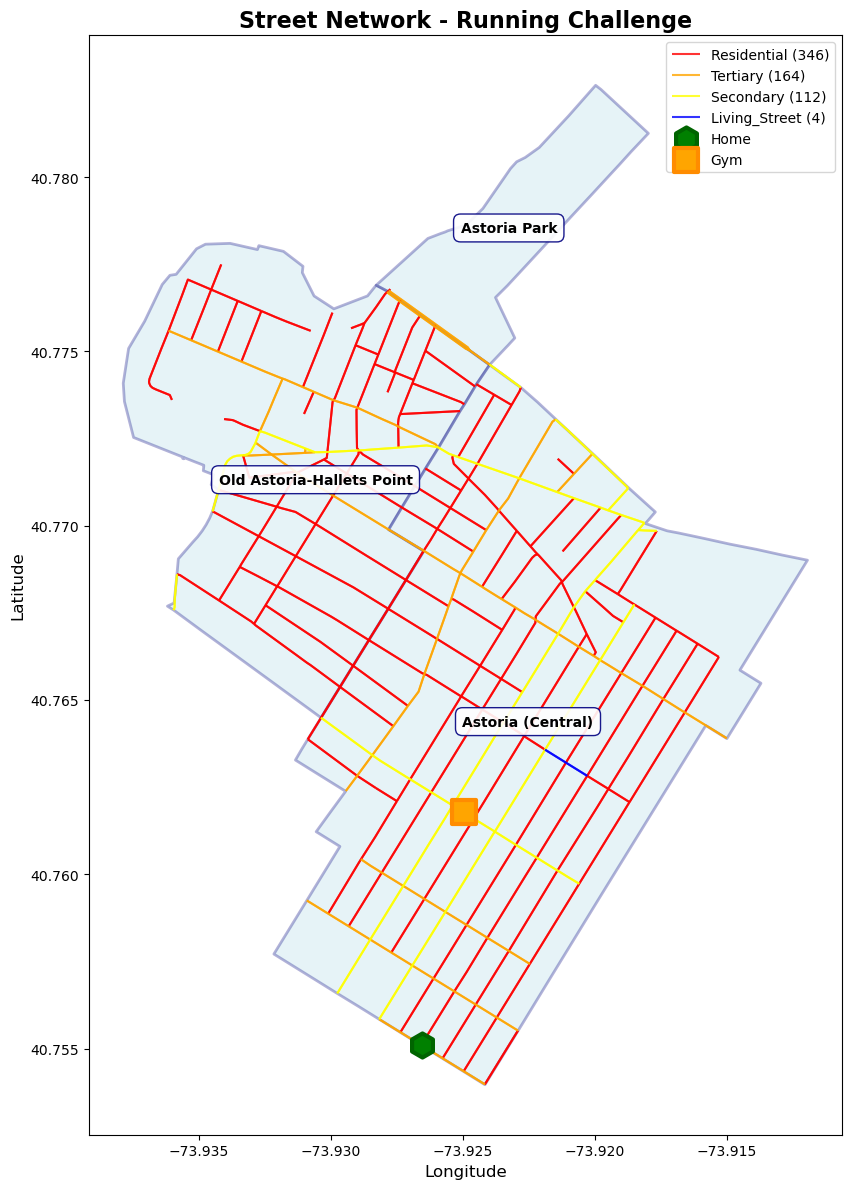


📊 G_final_streets Network Analysis:
   • residential    :  346 segments,   33.4 miles
   • tertiary       :  164 segments,    9.0 miles
   • secondary      :  112 segments,    8.3 miles
   • living_street  :    4 segments,    0.2 miles

   • TOTAL NETWORK:  626 segments,   50.9 miles
   • Reduction from original: 91.3% fewer segments


In [8]:
import geopandas as gpd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

# --- ENHANCED Visualization for G_final_streets ---

print("🎨 Creating detailed visualization of G_final_streets...")

# Create visualization with proper breakdown by street type
fig, ax = plt.subplots(figsize=(15, 12))


# Plot neighborhood boundaries first
gdf_astoria.plot(ax=ax, facecolor='lightblue', edgecolor='navy', alpha=0.3, linewidth=2)

astoria_boundary = unary_union(gdf_astoria.geometry.values)

street_types_to_keep = [
    'residential',
    'tertiary',
    'secondary',
    'unclassified',
    'living_street'
]

G_final_streets = ox.graph_from_polygon(
    astoria_boundary,
    network_type='walk',
    custom_filter=f'["highway"~"{"|".join(street_types_to_keep)}"]'
)


# Convert G_final_streets to GeoDataFrame
nodes_final, edges_final = ox.graph_to_gdfs(G_final_streets)

print(f"📊 G_final_streets contains {len(edges_final)} edges")

# Define colors for each street type
running_types_colors = {
    'residential': 'red',
    'tertiary': 'orange', 
    'secondary': 'yellow',
    'unclassified': 'green',
    'living_street': 'blue'
}

# Plot streets by type with different colors
for highway_type, color in running_types_colors.items():
    # Filter edges for this highway type
    type_edges = edges_final[edges_final['highway'].astype(str).str.contains(highway_type, na=False)]
    
    if not type_edges.empty:
        type_edges.plot(ax=ax, color=color, linewidth=1.5, alpha=0.8, label=f'{highway_type.title()} ({len(type_edges)})')
        print(f"   • {highway_type}: {len(type_edges)} segments")
    else:
        print(f"   • {highway_type}: 0 segments")

# Add home and gym markers (make sure coordinates are defined)
if 'home' in globals():
    ax.scatter(home[1], home[0], c='green', s=300, marker='h', 
               label='Home', zorder=10, edgecolors='darkgreen', linewidth=3)
if 'gym' in globals():
    ax.scatter(gym[1], gym[0], c='orange', s=300, marker='s', 
               label='Gym', zorder=10, edgecolors='darkorange', linewidth=3)

# Add neighborhood labels
for _, row in gdf_astoria.iterrows():
    p = row.geometry.representative_point()
    ax.annotate(
        row["NTAName"],
        xy=(p.x, p.y),
        ha="center", va="center",
        fontsize=10, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", 
                 alpha=0.9, edgecolor="navy")
    )

# Styling
ax.set_title("Street Network - Running Challenge", fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

# --- Calculate and Display Statistics ---
print(f"\n📊 G_final_streets Network Analysis:")
print("=" * 50)

# Calculate total distance by type
total_distance_by_type = {}
total_distance_all = 0

for highway_type in running_types_colors.keys():
    type_edges = edges_final[edges_final['highway'].astype(str).str.contains(highway_type, na=False)]
    if not type_edges.empty and 'length' in type_edges.columns:
        distance_miles = (type_edges['length'] * 0.000621371).sum()
        total_distance_by_type[highway_type] = distance_miles
        total_distance_all += distance_miles
        print(f"   • {highway_type:<15}: {len(type_edges):>4} segments, {distance_miles:>6.1f} miles")

print(f"\n   • TOTAL NETWORK: {len(edges_final):>4} segments, {total_distance_all:>6.1f} miles")

# Compare with original network if available
if 'G' in globals():
    original_edges = len(G.edges())
    reduction_percentage = ((original_edges - len(edges_final)) / original_edges) * 100
    print(f"   • Reduction from original: {reduction_percentage:.1f}% fewer segments")

print("=" * 50)

🔗 Clustering nearby vertices to reduce visual clutter...
   • Original important intersections: 362
   • Clustered into: 161 groups
   • Average reduction: 201 merged vertices
   • Original important intersections: 362
   • Clustered into: 161 groups
   • Average reduction: 201 merged vertices


/var/folders/l6/7c34hv4d1qxf6512mr1v27cc0000gn/T/ipykernel_18497/2484720632.py:134: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l6/7c34hv4d1qxf6512mr1v27cc0000gn/T/ipykernel_18497/2484720632.py:134: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


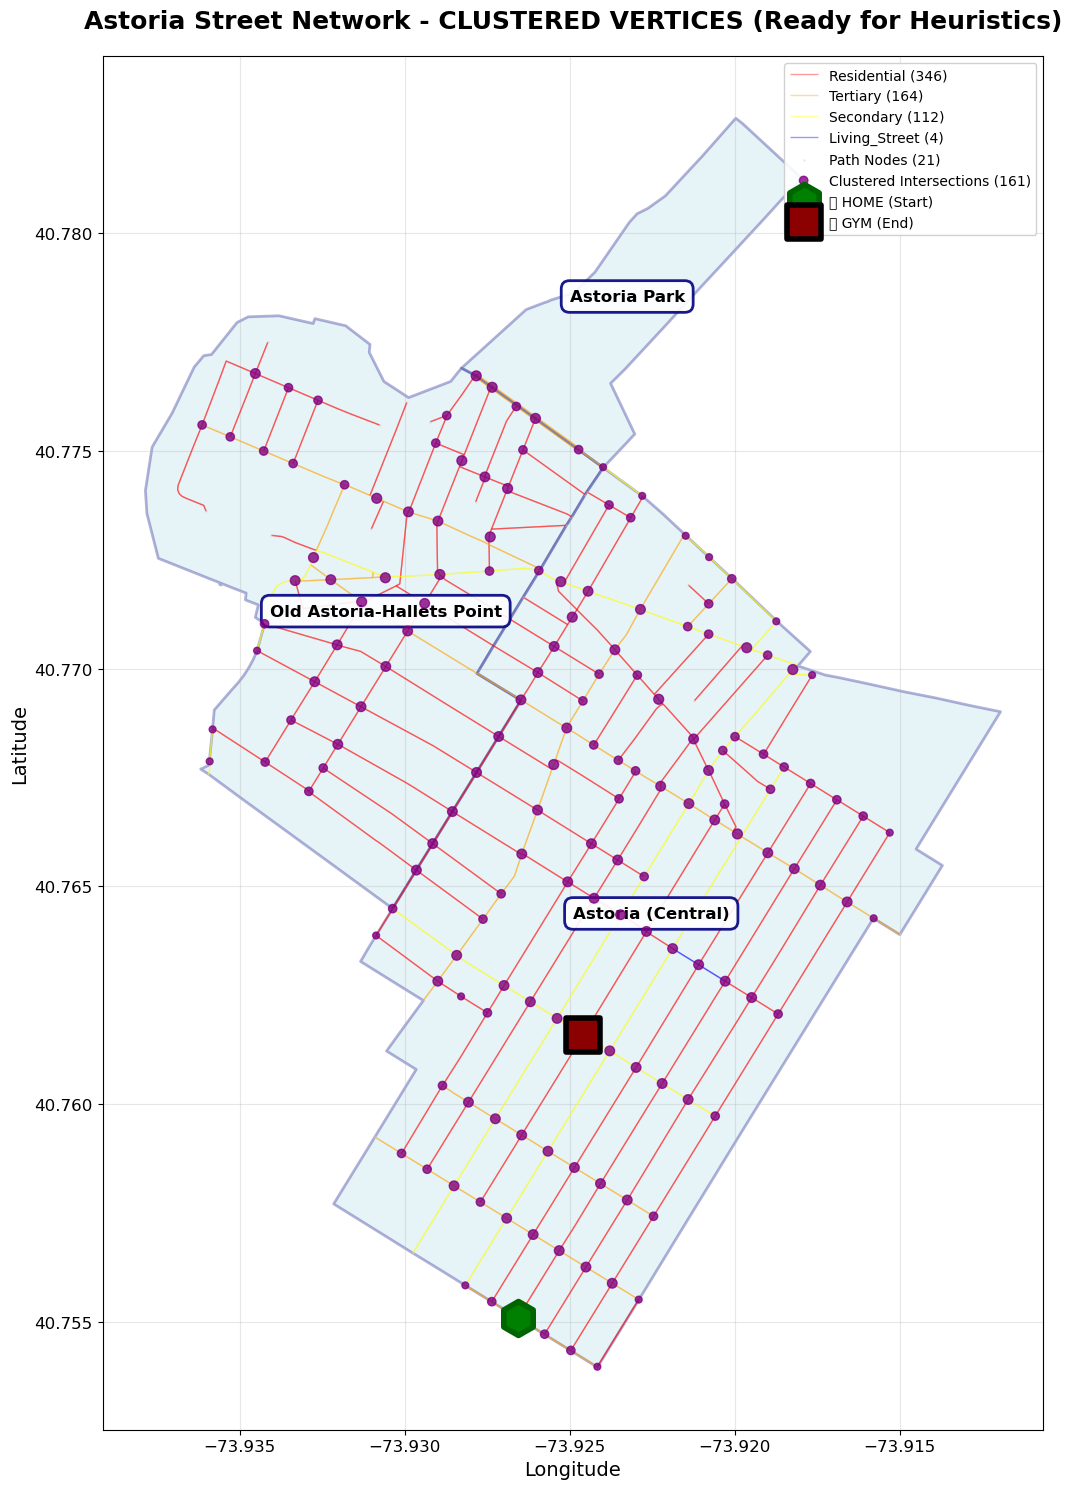


✅ Network with CLUSTERED VERTICES ready for optimization!
   • Total original vertices: 202 nodes
   • Clustered important intersections: 161 strategic points
   • Graph variable: G_final_streets
   • Home node: 42866667
   • Gym node: 42882974
   • Ready for efficient heuristic algorithm with reduced complexity!


In [9]:
# --- CLUSTER NEARBY VERTICES TO REDUCE CLUTTER ---

print("🔗 Clustering nearby vertices to reduce visual clutter...")

from sklearn.cluster import DBSCAN
import numpy as np

# Get node degrees to categorize intersections
degrees = dict(G_final_streets.degree())

# Categorize nodes by their degree (number of connections)
dead_ends = [node for node, degree in degrees.items() if degree == 1]
simple_paths = [node for node, degree in degrees.items() if degree == 2]
intersections = [node for node, degree in degrees.items() if degree >= 3]
major_intersections = [node for node, degree in degrees.items() if degree >= 4]

# Extract coordinates of all intersections and major intersections for clustering
all_important_nodes = intersections + major_intersections
if all_important_nodes:
    # Get coordinates for clustering
    coords = np.array([(G_final_streets.nodes[node]['y'], G_final_streets.nodes[node]['x']) for node in all_important_nodes])
    
    # Define clustering parameters
    cluster_radius_meters = 50  # Merge vertices within 50 meters
    meters_to_degrees = 1 / 111320  # Rough conversion
    eps = cluster_radius_meters * meters_to_degrees
    
    # Perform clustering
    clustering = DBSCAN(eps=eps, min_samples=1, algorithm='ball_tree').fit(coords)
    labels = clustering.labels_
    
    # Create clustered vertices by finding cluster centroids
    clustered_vertices = []
    unique_labels = set(labels)
    
    for label in unique_labels:
        cluster_mask = (labels == label)
        cluster_coords = coords[cluster_mask]
        cluster_nodes = [all_important_nodes[i] for i, mask in enumerate(cluster_mask) if mask]
        
        # Calculate centroid of the cluster
        centroid_lat = cluster_coords[:, 0].mean()
        centroid_lon = cluster_coords[:, 1].mean()
        
        # Calculate cluster importance (sum of degrees)
        cluster_importance = sum(G_final_streets.degree(node) for node in cluster_nodes)
        
        clustered_vertices.append({
            'lat': centroid_lat,
            'lon': centroid_lon,
            'importance': cluster_importance,
            'node_count': len(cluster_nodes),
            'nodes': cluster_nodes
        })
    
    print(f"   • Original important intersections: {len(all_important_nodes)}")
    print(f"   • Clustered into: {len(clustered_vertices)} groups")
    print(f"   • Average reduction: {(len(all_important_nodes) - len(clustered_vertices))} merged vertices")

# --- CREATE VISUALIZATION WITH CLUSTERED VERTICES ---

fig, ax = plt.subplots(figsize=(18, 15))

# Plot neighborhood boundaries first
gdf_astoria.plot(ax=ax, facecolor='lightblue', edgecolor='navy', alpha=0.3, linewidth=2)

# Plot streets by type with lighter colors (as background)
for highway_type, color in running_types_colors.items():
    type_edges = edges_final[edges_final['highway'].astype(str).str.contains(highway_type, na=False)]
    
    if not type_edges.empty:
        type_edges.plot(ax=ax, color=color, linewidth=1, alpha=0.4, label=f'{highway_type.title()} ({len(type_edges)})')

# Plot simple path nodes (very small, background)
if simple_paths:
    simple_coords = [(G_final_streets.nodes[node]['y'], G_final_streets.nodes[node]['x']) for node in simple_paths]
    simple_lats, simple_lons = zip(*simple_coords)
    ax.scatter(simple_lons, simple_lats, c='lightgray', s=1, alpha=0.3, 
               label=f'Path Nodes ({len(simple_paths)})', zorder=2)

# Plot dead ends (small red dots)
if dead_ends:
    dead_coords = [(G_final_streets.nodes[node]['y'], G_final_streets.nodes[node]['x']) for node in dead_ends]
    dead_lats, dead_lons = zip(*dead_coords)
    ax.scatter(dead_lons, dead_lats, c='red', s=6, alpha=0.7, 
               label=f'Dead Ends ({len(dead_ends)})', zorder=3)

# Plot CLUSTERED vertices with size based on importance
if all_important_nodes and clustered_vertices:
    cluster_lats = [v['lat'] for v in clustered_vertices]
    cluster_lons = [v['lon'] for v in clustered_vertices]
    cluster_sizes = [min(v['importance'] * 3, 50) for v in clustered_vertices]  # Scale size, max 50
    cluster_colors = ['purple' if v['importance'] >= 8 else 'orange' for v in clustered_vertices]
    
    ax.scatter(cluster_lons, cluster_lats, c=cluster_colors, s=cluster_sizes, alpha=0.8, 
               label=f'Clustered Intersections ({len(clustered_vertices)})', zorder=5)

# Add HOME and GYM markers
home = (40.75398104561959, -73.92721746021077)
gym = (40.762049034238565, -73.92476009837436)

home_node = ox.nearest_nodes(G_final_streets, home[1], home[0])
gym_node = ox.nearest_nodes(G_final_streets, gym[1], gym[0])

home_coords = G_final_streets.nodes[home_node]
gym_coords = G_final_streets.nodes[gym_node]

ax.scatter(home_coords['x'], home_coords['y'], c='green', s=600, marker='h', 
           label='🏠 HOME (Start)', zorder=10, edgecolors='darkgreen', linewidth=4)
ax.scatter(gym_coords['x'], gym_coords['y'], c='darkred', s=600, marker='s', 
           label='🏋️ GYM (End)', zorder=10, edgecolors='black', linewidth=4)

# Add neighborhood labels
for _, row in gdf_astoria.iterrows():
    p = row.geometry.representative_point()
    ax.annotate(
        row["NTAName"],
        xy=(p.x, p.y),
        ha="center", va="center",
        fontsize=12, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", 
                 alpha=0.9, edgecolor="navy", linewidth=2)
    )

# Styling
ax.set_title("Astoria Street Network - CLUSTERED VERTICES (Ready for Heuristics)", 
             fontsize=18, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Network with CLUSTERED VERTICES ready for optimization!")
print(f"   • Total original vertices: {len(nodes_final)} nodes")
print(f"   • Clustered important intersections: {len(clustered_vertices)} strategic points")
print(f"   • Graph variable: G_final_streets")
print(f"   • Home node: {home_node}")
print(f"   • Gym node: {gym_node}")
print(f"   • Ready for efficient heuristic algorithm with reduced complexity!")

## Phase 2: Initial Solution - The Greedy Heuristic ➡️
The greddy heauristic would help us to get quick solutions to our problem. With all our vertices ready we would create different run routes that would cover all the vertices. after this, we would optimize the greedy heauristic with the ALNS method.  


In [17]:
import time
import networkx as nx
import math

# --- Setup Required Variables ---
print("🔧 Setting up required variables...")

# Define route distance constraints if not already defined
if 'MIN_ROUTE_DISTANCE' not in globals():
    MIN_ROUTE_DISTANCE = 6.0  # miles
if 'MAX_ROUTE_DISTANCE' not in globals():
    MAX_ROUTE_DISTANCE = 10.0  # miles

# Create uncovered_edges set if not already defined
if 'uncovered_edges' not in globals():
    print("   • Creating uncovered_edges set from G_final_streets...")
    uncovered_edges = set()
    for u, v, k in G_final_streets.edges(keys=True):
        uncovered_edges.add((u, v, k))
    print(f"   • Created {len(uncovered_edges)} uncovered edges")

print(f"   • MIN_ROUTE_DISTANCE: {MIN_ROUTE_DISTANCE} miles")
print(f"   • MAX_ROUTE_DISTANCE: {MAX_ROUTE_DISTANCE} miles")
print(f"   • Available uncovered edges: {len(uncovered_edges)}")

# --- ULTRA-RIGID Greedy with Extreme Turn Penalties ---

print("\n🏃‍♂️ Starting ULTRA-RIGID algorithm with extreme turn penalties...")
start_time = time.time()

# Helper function to calculate path distance
def get_path_distance(graph, path):
    dist = 0
    for i in range(len(path) - 1):
        try:
            edge_data = graph.get_edge_data(path[i], path[i+1])
            if edge_data:
                edge_lengths = [data['length'] for data in edge_data.values()]
                dist += min(edge_lengths)
        except Exception as e:
            print(f"Error getting edge data: {e}")
    return dist

# Helper function to calculate bearing between two nodes
def get_bearing(graph, node1, node2):
    """Calculate bearing in degrees from node1 to node2"""
    try:
        x1, y1 = graph.nodes[node1]['x'], graph.nodes[node1]['y']
        x2, y2 = graph.nodes[node2]['x'], graph.nodes[node2]['y']
        
        # Convert to radians for calculation
        lat1, lon1 = math.radians(y1), math.radians(x1)
        lat2, lon2 = math.radians(y2), math.radians(x2)
        
        dlon = lon2 - lon1
        y = math.sin(dlon) * math.cos(lat2)
        x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dlon)
        
        bearing = math.atan2(y, x)
        bearing = math.degrees(bearing)
        bearing = (bearing + 360) % 360  # Normalize to 0-360
        
        return bearing
    except (KeyError, ZeroDivisionError):
        return None

# Helper function to calculate EXTREME turn penalty
def get_ultra_rigid_penalty(prev_bearing, current_bearing):
    """Calculate EXTREME penalty to force straight-line behavior"""
    if prev_bearing is None or current_bearing is None:
        return 1.0  # No penalty for first segment
    
    # Calculate turn angle
    angle_diff = abs(current_bearing - prev_bearing)
    if angle_diff > 180:
        angle_diff = 360 - angle_diff
    
    # EXTREME penalty factors - MUCH more rigid:
    # 0-5°: Big bonus (very straight)
    # 5-15°: Small bonus (essentially straight)
    # 15-30°: Neutral (minor adjustment)
    # 30-45°: Heavy penalty (noticeable turn)
    # 45-90°: MASSIVE penalty (significant turn)
    # 90°+: ASTRONOMICAL penalty (sharp turn/U-turn)
    
    if angle_diff <= 5:
        return 0.2      # 80% bonus for perfectly straight
    elif angle_diff <= 10:
        return 0.4      # 60% bonus for very straight
    elif angle_diff <= 15:
        return 0.6      # 40% bonus for essentially straight
    elif angle_diff <= 20:
        return 0.8      # 20% bonus for minor adjustments
    elif angle_diff <= 30:
        return 1.0      # No penalty for very gentle turns
    elif angle_diff <= 45:
        return 5.0      # 500% penalty for noticeable turns
    elif angle_diff <= 60:
        return 15.0     # 1500% penalty for moderate turns
    elif angle_diff <= 90:
        return 50.0     # 5000% penalty for sharp turns
    elif angle_diff <= 120:
        return 200.0    # 20000% penalty for very sharp turns
    else:
        return 1000.0   # 100000% penalty for U-turns

# Helper function to check if we can continue straight for minimum distance
def can_continue_straight(graph, start_node, bearing, min_straight_distance=200):
    """Check if we can continue in roughly the same direction for a minimum distance"""
    current_node = start_node
    total_distance = 0
    
    for _ in range(10):  # Max 10 hops to find straight continuation
        neighbors = list(graph.neighbors(current_node))
        best_neighbor = None
        best_angle_diff = float('inf')
        
        for neighbor in neighbors:
            neighbor_bearing = get_bearing(graph, current_node, neighbor)
            if neighbor_bearing is not None:
                angle_diff = abs(neighbor_bearing - bearing)
                if angle_diff > 180:
                    angle_diff = 360 - angle_diff
                
                # Look for very straight continuation (within 10 degrees)
                if angle_diff <= 10 and angle_diff < best_angle_diff:
                    best_angle_diff = angle_diff
                    best_neighbor = neighbor
        
        if best_neighbor is None:
            break
            
        # Add distance to this neighbor
        edge_data = graph.get_edge_data(current_node, best_neighbor)
        if edge_data:
            edge_lengths = [data['length'] for data in edge_data.values()]
            total_distance += min(edge_lengths)
        
        if total_distance >= min_straight_distance:
            return True
            
        current_node = best_neighbor
    
    return total_distance >= min_straight_distance

# --- Main Algorithm ---
generated_runs = []
run_count = 0

# Use the existing uncovered_edges set, but make a copy to work with
remaining_uncovered = uncovered_edges.copy()
print(f"Working with {len(remaining_uncovered)} uncovered edges")

# Convert MIN_ROUTE_DISTANCE from miles to meters for comparison
MIN_DISTANCE_METERS = MIN_ROUTE_DISTANCE * 1609.34

while remaining_uncovered:
    run_count += 1
    print(f"\n--- Building Run #{run_count} ---")
    
    # Start each route from home
    current_path = [home_node]
    current_bearing = None  # Track the current direction
    consecutive_straight_count = 0  # Track how many straight segments we've had
    
    # 1. Grow the path until it meets the minimum distance
    while get_path_distance(G_final_streets, current_path) < MIN_DISTANCE_METERS:
        if not remaining_uncovered:
            print("   - All streets covered.")
            break
            
        last_node = current_path[-1]
        
        # Calculate distances to all nodes from last_node
        try:
            distances = nx.single_source_dijkstra_path_length(G_final_streets, source=last_node, weight='length')
        except Exception as e:
            print(f"   - Error calculating distances: {e}")
            break
        
        # Find the best edge with EXTREME rigidity
        best_edge = None
        best_score = float('inf')
        best_target = None
        best_bearing = None
        
        for edge in remaining_uncovered:
            if len(edge) >= 2:
                u, v = edge[0], edge[1]
                
                # Calculate distance to both ends of the edge
                dist_to_u = distances.get(u, float('inf'))
                dist_to_v = distances.get(v, float('inf'))
                
                if dist_to_u == float('inf') and dist_to_v == float('inf'):
                    continue
                
                # Try both directions and pick the best one
                for target_node, edge_end, min_dist in [(u, v, dist_to_u), (v, u, dist_to_v)]:
                    if min_dist == float('inf'):
                        continue
                    
                    # Calculate bearing to this target
                    new_bearing = get_bearing(G_final_streets, last_node, target_node)
                    
                    # Calculate EXTREME turn penalty
                    turn_penalty = get_ultra_rigid_penalty(current_bearing, new_bearing)
                    
                    # ADDITIONAL: Straight-line continuation bonus
                    straight_bonus = 1.0
                    if new_bearing is not None:
                        # Big bonus if we can continue straight for a long distance
                        if can_continue_straight(G_final_streets, target_node, new_bearing, 300):
                            straight_bonus = 0.3  # 70% bonus for long straight potential
                        elif can_continue_straight(G_final_streets, target_node, new_bearing, 150):
                            straight_bonus = 0.5  # 50% bonus for medium straight potential
                    
                    # Distance penalty (prefer closer edges, but heavily outweighed by turn penalty)
                    distance_penalty = 1.0 + (min_dist / 2000.0)  # Much smaller distance influence
                    
                    # Street type bonus (prefer main streets for longer straight segments)
                    street_bonus = 1.0
                    try:
                        edge_data = G_final_streets.get_edge_data(u, v)
                        if edge_data:
                            for key, data in edge_data.items():
                                highway_type = data.get('highway', 'unknown')
                                if 'tertiary' in str(highway_type):
                                    street_bonus = 0.6  # 40% bonus for tertiary roads
                                elif 'secondary' in str(highway_type):
                                    street_bonus = 0.4  # 60% bonus for secondary roads
                                break
                    except:
                        pass
                    
                    # EXTREME scoring: turn penalty dominates everything
                    score = min_dist * turn_penalty * distance_penalty * street_bonus * straight_bonus
                    
                    if score < best_score:
                        best_score = score
                        best_edge = edge
                        best_target = target_node
                        best_bearing = new_bearing

        if best_edge is None:
            print("   - Warning: Could not find a path to any remaining uncovered edges.")
            break

        try:
            # Get path to the best target
            path_to_next_edge = nx.shortest_path(G_final_streets, source=last_node, target=best_target, weight='length')
            
            # Extend current path (avoid duplicating the last node)
            current_path.extend(path_to_next_edge[1:])
            
            # Add the other end of the edge to complete the street segment
            u, v = best_edge[0], best_edge[1]
            other_end = v if best_target == u else u
            current_path.append(other_end)
            
            # Update current bearing and straight count
            if current_bearing is not None and best_bearing is not None:
                angle_diff = abs(best_bearing - current_bearing)
                if angle_diff > 180:
                    angle_diff = 360 - angle_diff
                    
                if angle_diff <= 15:  # Very straight
                    consecutive_straight_count += 1
                else:
                    consecutive_straight_count = 0
            
            current_bearing = best_bearing
            
            # Remove the covered edge from uncovered set
            remaining_uncovered.discard(best_edge)
            # Also remove the reverse edge if it exists
            if len(best_edge) == 3:
                reverse_edge = (v, u, best_edge[2])
            else:
                reverse_edge = (v, u)
            remaining_uncovered.discard(reverse_edge)

            current_distance_miles = get_path_distance(G_final_streets, current_path) / 1609.34
            print(f"   - Added edge {u}->{v}. Distance: {current_distance_miles:.2f}mi. Straight count: {consecutive_straight_count}")
            
        except nx.NetworkXNoPath:
            print(f"   - No path found to edge {best_edge}. Removing from uncovered set.")
            remaining_uncovered.discard(best_edge)
            continue
        except Exception as e:
            print(f"   - Error processing edge {best_edge}: {e}")
            remaining_uncovered.discard(best_edge)
            continue

    # 2. Complete the run by adding the path to the gym
    if current_path[-1] != gym_node:
        try:
            last_node = current_path[-1]
            path_to_gym = nx.shortest_path(G_final_streets, source=last_node, target=gym_node, weight='length')
            current_path.extend(path_to_gym[1:])
        except nx.NetworkXNoPath:
            print(f"   - Warning: No path found from {last_node} to gym. Ending route at current location.")
        except Exception as e:
            print(f"   - Error finding path to gym: {e}")
    
    # 3. Finalize and store the run
    final_distance_miles = get_path_distance(G_final_streets, current_path) / 1609.34
    
    generated_runs.append({
        'run_id': run_count,
        'path': current_path,
        'distance_miles': final_distance_miles
    })
    print(f"✅ Finished Run #{run_count}. Final distance: {final_distance_miles:.2f} miles.")
    
    # Safety check to prevent infinite loops
    if run_count > 50:
        print("   - Safety limit reached (50 runs). Stopping algorithm.")
        break

# --- Summary of the Generated Plan ---
end_time = time.time()
print("\n" + "="*50)
print("ULTRA-RIGID Greedy Heuristic with Extreme Turn Penalties - Summary")
print("="*50)
print(f"Algorithm runtime: {end_time - start_time:.2f} seconds.")

if generated_runs:
    runs_df = pd.DataFrame(generated_runs)
    total_miles_run = runs_df['distance_miles'].sum()
    
    print(f"Generated a total of {len(runs_df)} runs.")
    print(f"Total distance to run across all routes: {total_miles_run:.2f} miles.")
    print(f"Average distance per run: {runs_df['distance_miles'].mean():.2f} miles.")
    print(f"Minimum run distance: {runs_df['distance_miles'].min():.2f} miles.")
    print(f"Maximum run distance: {runs_df['distance_miles'].max():.2f} miles.")
    
    # Calculate coverage
    edges_covered_count = len(uncovered_edges) - len(remaining_uncovered)
    coverage_percentage = (edges_covered_count / len(uncovered_edges)) * 100 if uncovered_edges else 0
    print(f"Street coverage: {edges_covered_count}/{len(uncovered_edges)} edges ({coverage_percentage:.1f}%)")
    
    print("\n--- Run Details ---")
    print(runs_df[['run_id', 'distance_miles']].round(2))
    
    # Store the results for later use
    optimized_greedy_solution = {
        'runs': generated_runs,
        'total_distance': total_miles_run,
        'coverage_percentage': coverage_percentage,
        'algorithm_time': end_time - start_time
    }
    
else:
    print("No runs were generated.")
    optimized_greedy_solution = None

print("="*50)

🔧 Setting up required variables...
   • MIN_ROUTE_DISTANCE: 8.0 miles
   • MAX_ROUTE_DISTANCE: 12.0 miles
   • Available uncovered edges: 626

🏃‍♂️ Starting ULTRA-RIGID algorithm with extreme turn penalties...
Working with 626 uncovered edges

--- Building Run #1 ---
   - Added edge 42866667->42926398. Distance: 0.05mi. Straight count: 0
   - Added edge 42888668->42926398. Distance: 0.10mi. Straight count: 1
   - Added edge 42888664->42888668. Distance: 0.22mi. Straight count: 2
   - Added edge 42888664->42824152. Distance: 0.35mi. Straight count: 3
   - Added edge 42824149->42824152. Distance: 0.40mi. Straight count: 4
   - Added edge 42926395->42824149. Distance: 0.52mi. Straight count: 5
   - Added edge 42926398->42926395. Distance: 0.65mi. Straight count: 6
   - Added edge 42882975->42824136. Distance: 1.23mi. Straight count: 7
   - Added edge 42882974->42882975. Distance: 1.28mi. Straight count: 8
   - Added edge 42856527->42882974. Distance: 1.47mi. Straight count: 9
   - Added e

🎨 Creating enhanced route visualizations...
🗺️ Showing first 3 routes...

📍 Visualizing Run #1
   • Distance: 9.39 miles
   • Nodes in path: 140


/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480

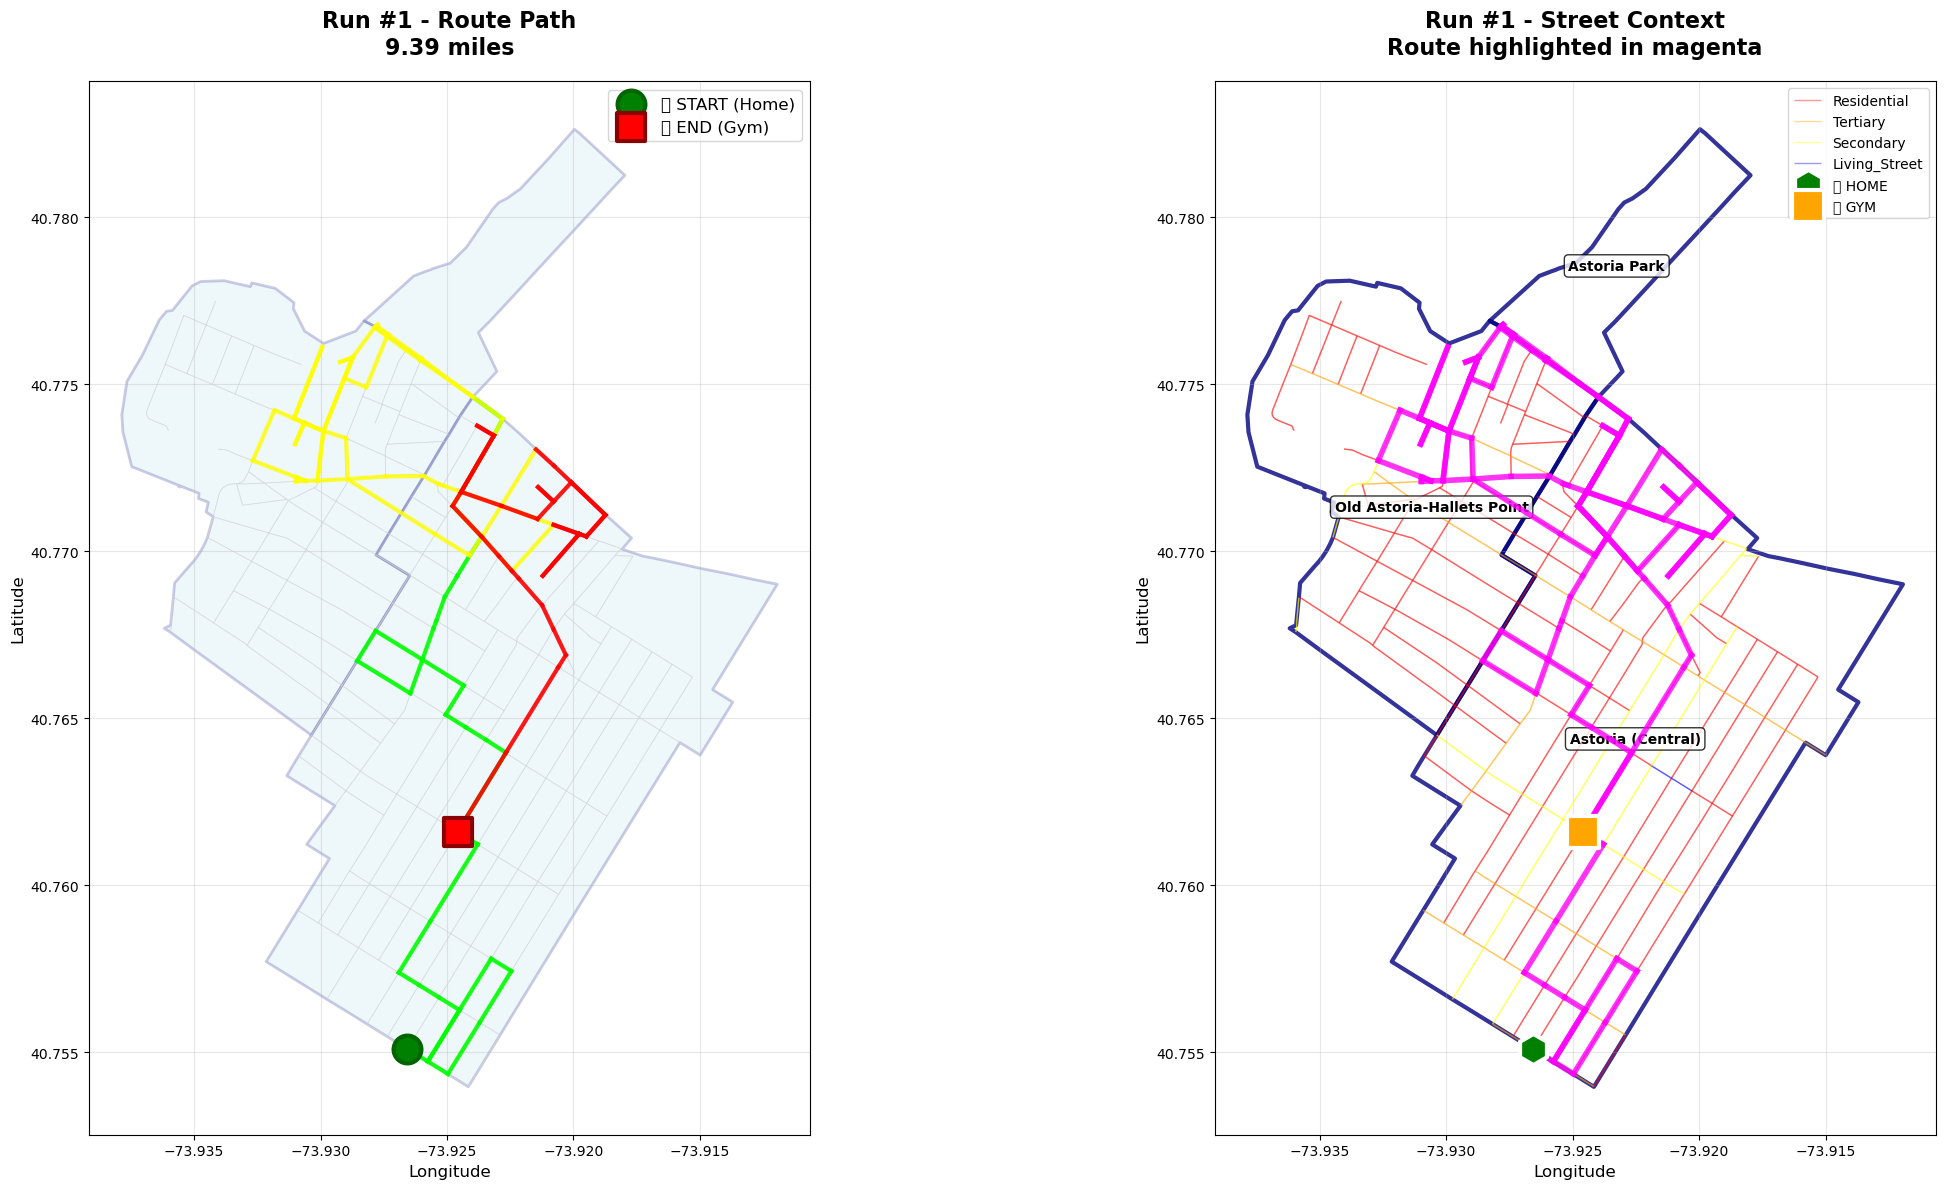


📊 Route Details:
   • Run ID: 1
   • Total distance: 9.39 miles
   • Number of nodes: 140
   • Starts at: Node 42866667 (Home area)
   • Ends at: Node 42882974 (Gym area)
   ✅ Route meets distance constraints (8.0-12.0 miles)

📍 Visualizing Run #2
   • Distance: 9.46 miles
   • Nodes in path: 135


/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480

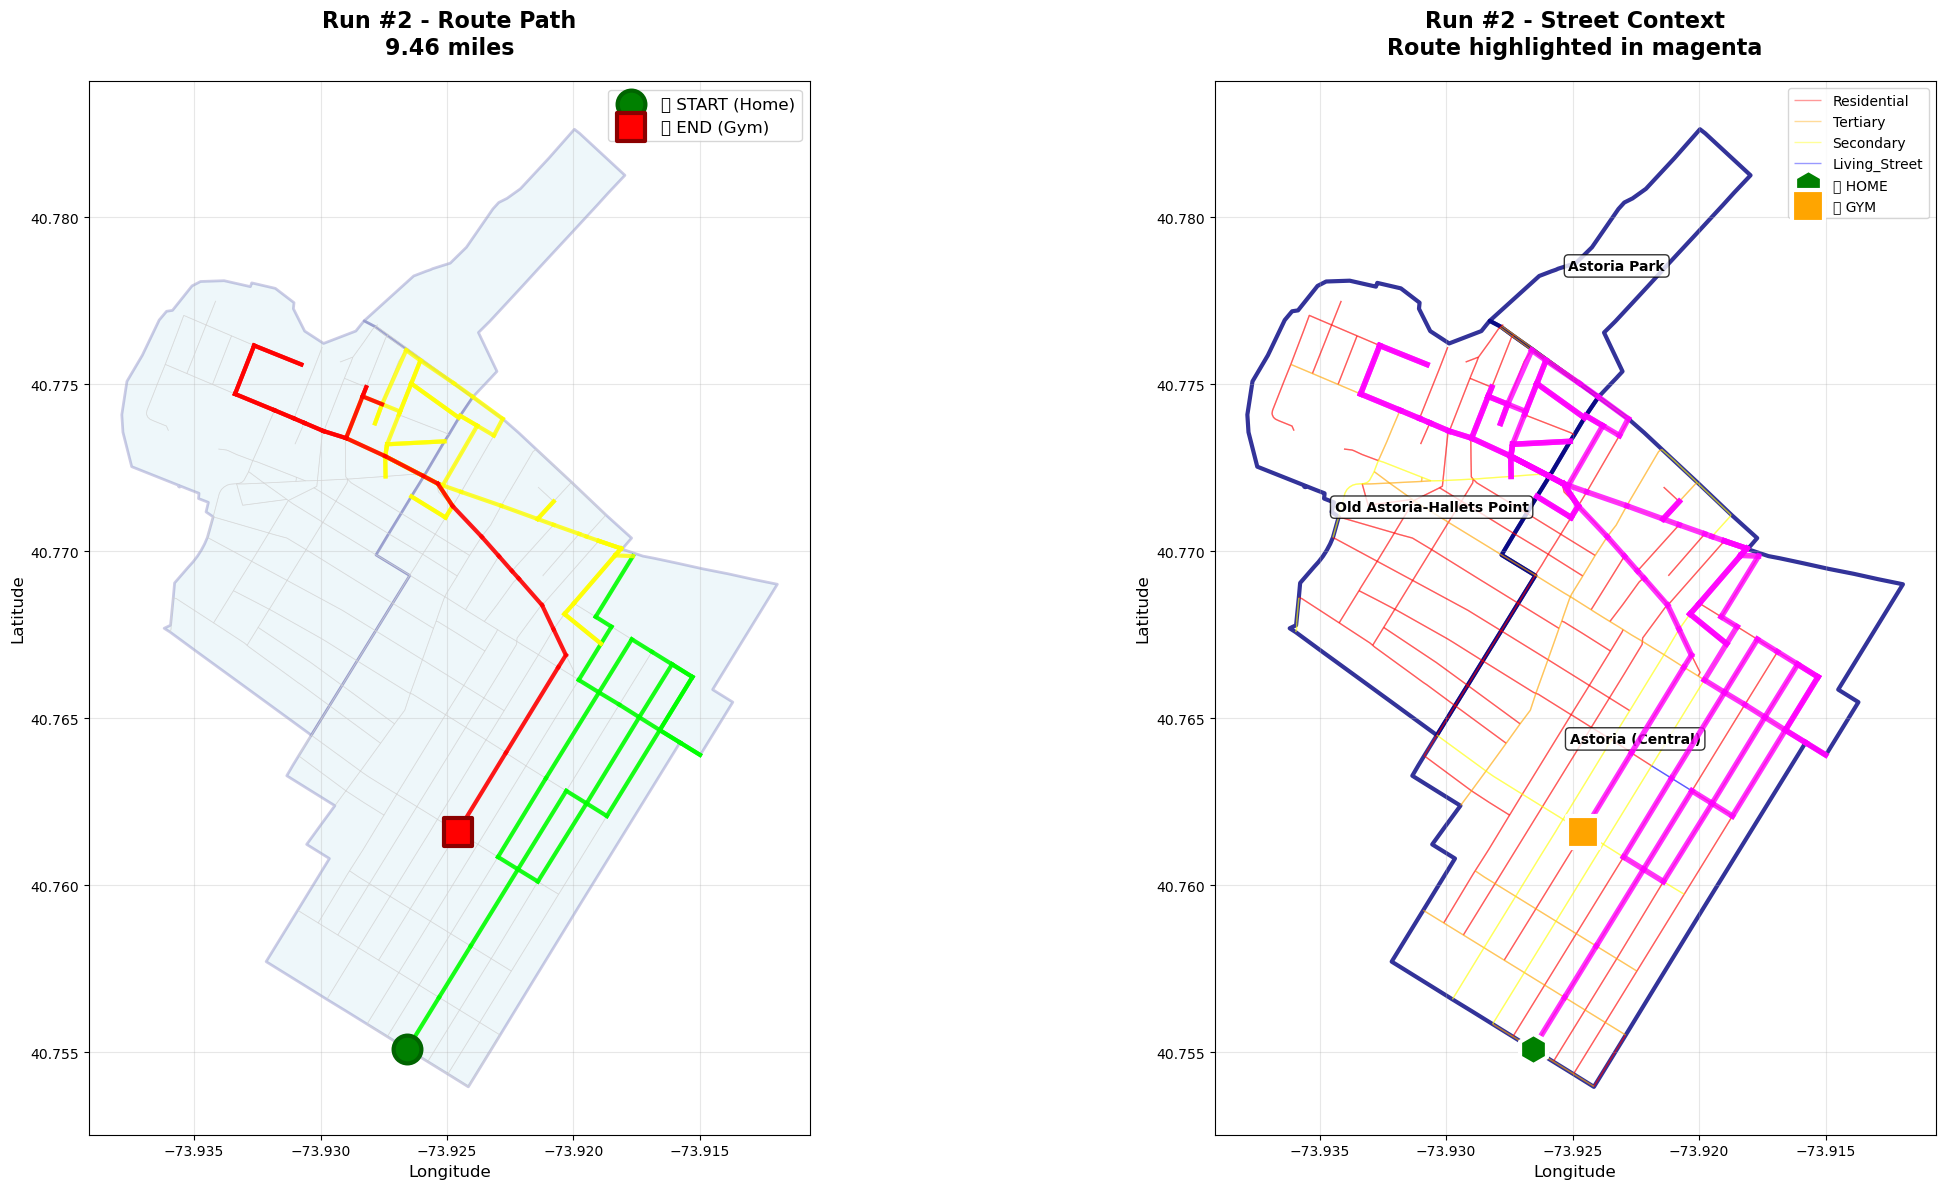


📊 Route Details:
   • Run ID: 2
   • Total distance: 9.46 miles
   • Number of nodes: 135
   • Starts at: Node 42866667 (Home area)
   • Ends at: Node 42882974 (Gym area)
   ✅ Route meets distance constraints (8.0-12.0 miles)

📍 Visualizing Run #3
   • Distance: 8.90 miles
   • Nodes in path: 116


/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/opt/anaconda3/lib/python3.13/site-packages/geopandas/plotting.py:480

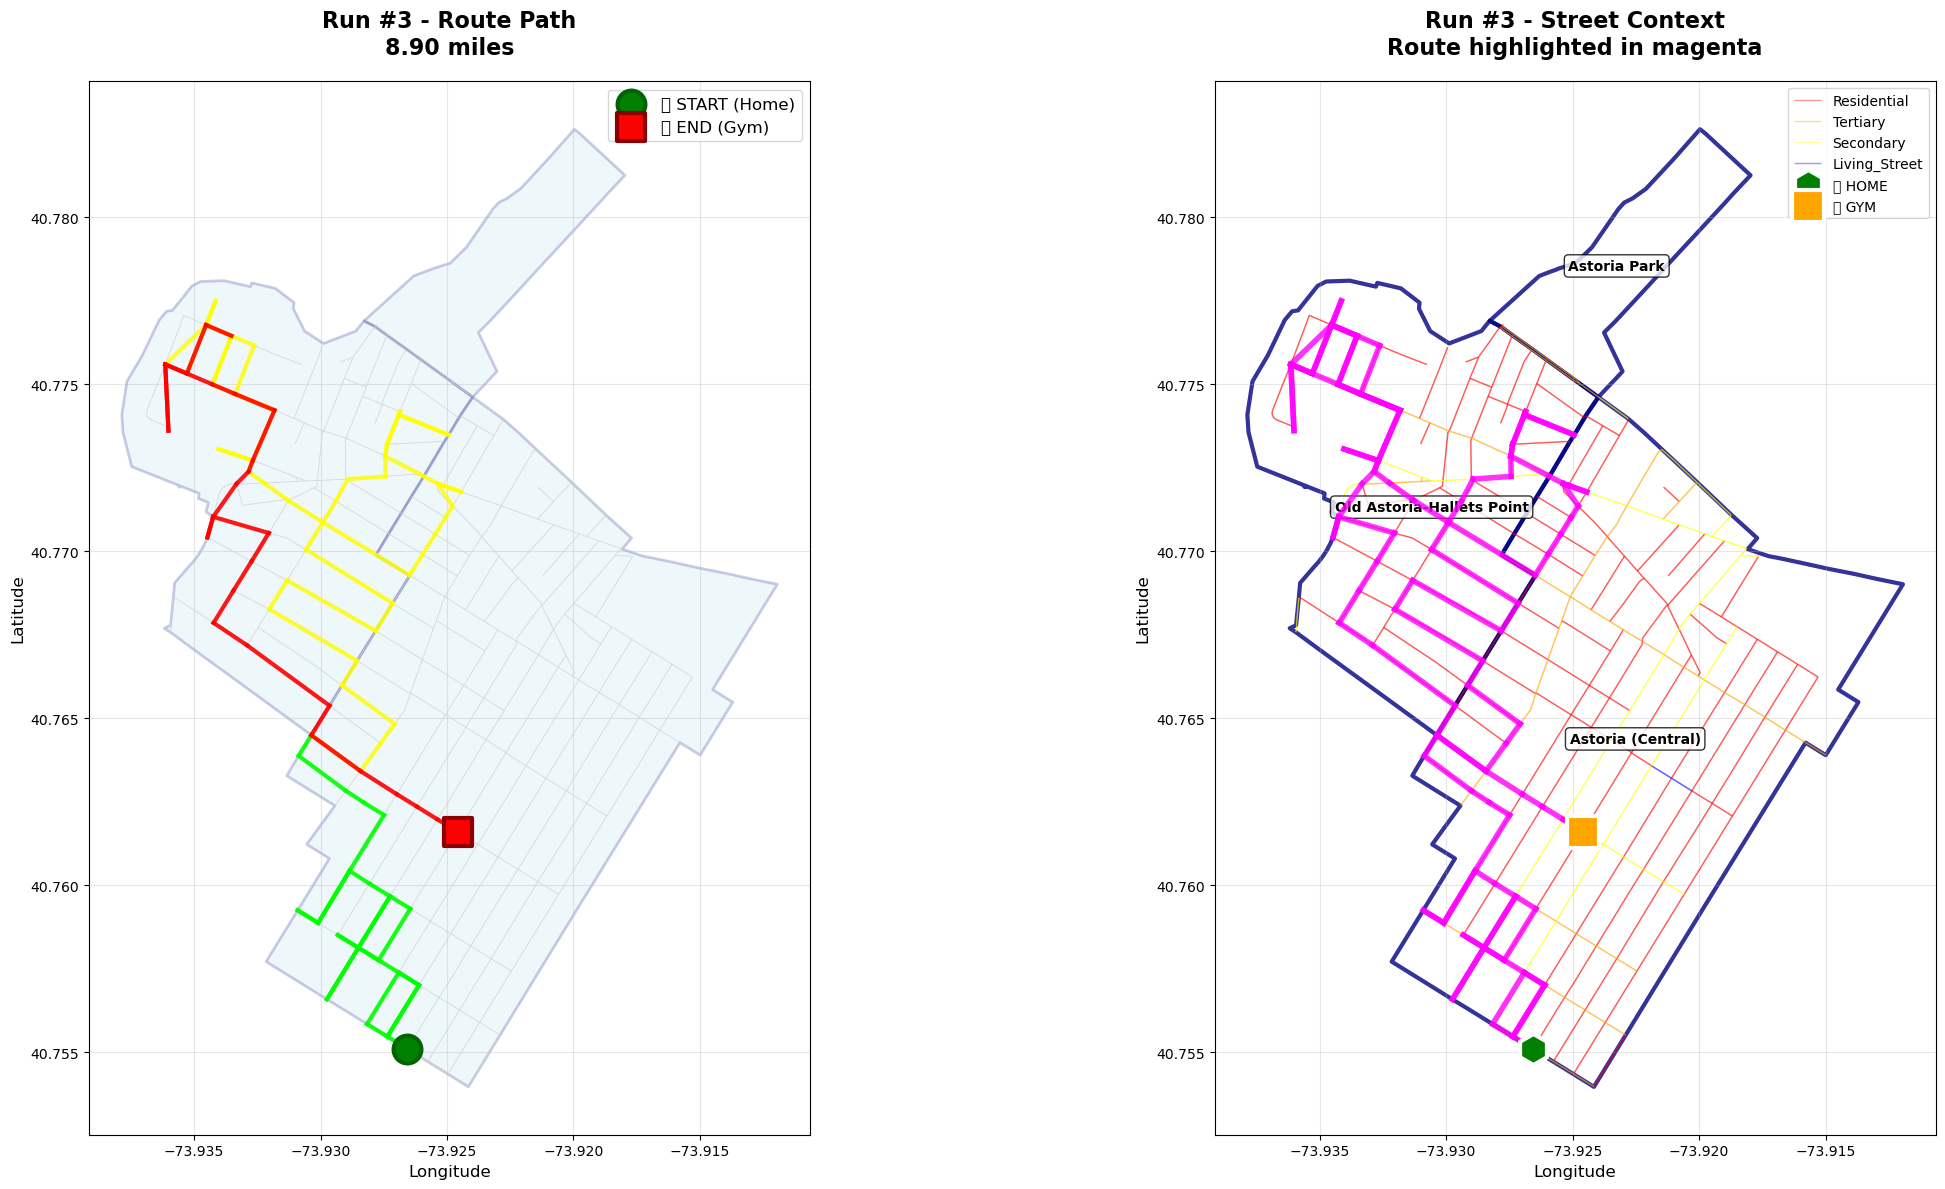


📊 Route Details:
   • Run ID: 3
   • Total distance: 8.90 miles
   • Number of nodes: 116
   • Starts at: Node 42866667 (Home area)
   • Ends at: Node 42882974 (Gym area)
   ✅ Route meets distance constraints (8.0-12.0 miles)

🏁 Total runs available: 6
💡 Call visualize_route(index) to see any specific run!


In [19]:
# --- Phase 7: Enhanced Route Visualization ---

print("🎨 Creating enhanced route visualizations...")

# Function to create better route visualization
def visualize_route(run_index=0, show_details=True):
    if not generated_runs or run_index >= len(generated_runs):
        print(f"❌ Run index {run_index} not available. Total runs: {len(generated_runs) if generated_runs else 0}")
        return
    
    run_data = generated_runs[run_index]
    route_path = run_data['path']
    route_distance = run_data['distance_miles']
    
    print(f"📍 Visualizing Run #{run_data['run_id']}")
    print(f"   • Distance: {route_distance:.2f} miles")
    print(f"   • Nodes in path: {len(route_path)}")
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(24, 12))
    
    # --- LEFT PLOT: Route on Street Network ---
    ax1 = axes[0]
    
    # Plot the Astoria boundary
    gdf_astoria.plot(ax=ax1, facecolor='lightblue', edgecolor='navy', alpha=0.2, linewidth=2)
    
    # Plot all streets in light gray as background
    edges_final.plot(ax=ax1, color='lightgray', linewidth=0.5, alpha=0.6)
    
    # Plot the route path with better styling
    route_edges = []
    for i in range(len(route_path) - 1):
        node1, node2 = route_path[i], route_path[i + 1]
        try:
            # Get coordinates for the edge
            x1, y1 = G_final_streets.nodes[node1]['x'], G_final_streets.nodes[node1]['y']
            x2, y2 = G_final_streets.nodes[node2]['x'], G_final_streets.nodes[node2]['y']
            
            # Color segments differently for start, middle, and end
            if i < len(route_path) // 4:
                color = 'lime'  # Start - bright green
                alpha = 0.9
            elif i > 3 * len(route_path) // 4:
                color = 'red'   # End - red
                alpha = 0.9
            else:
                color = 'yellow'  # Middle - yellow
                alpha = 0.8
            
            ax1.plot([x1, x2], [y1, y2], color=color, linewidth=3, alpha=alpha, zorder=5)
            
        except KeyError:
            continue
    
    # Add start and end markers
    if route_path:
        start_node = route_path[0]
        end_node = route_path[-1]
        
        start_x, start_y = G_final_streets.nodes[start_node]['x'], G_final_streets.nodes[start_node]['y']
        end_x, end_y = G_final_streets.nodes[end_node]['x'], G_final_streets.nodes[end_node]['y']
        
        ax1.scatter(start_x, start_y, c='green', s=400, marker='o', 
                   label='🟢 START (Home)', zorder=10, edgecolors='darkgreen', linewidth=3)
        ax1.scatter(end_x, end_y, c='red', s=400, marker='s', 
                   label='🔴 END (Gym)', zorder=10, edgecolors='darkred', linewidth=3)
    
    # Styling for left plot
    ax1.set_title(f"Run #{run_data['run_id']} - Route Path\n{route_distance:.2f} miles", 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.legend(loc='upper right', fontsize=12)
    ax1.set_xlabel("Longitude", fontsize=12)
    ax1.set_ylabel("Latitude", fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # --- RIGHT PLOT: Detailed Route with Street Context ---
    ax2 = axes[1]
    
    # Plot neighborhood boundaries
    gdf_astoria.plot(ax=ax2, facecolor='none', edgecolor='navy', alpha=0.8, linewidth=3)
    
    # Plot streets by type with different colors
    for highway_type, color in running_types_colors.items():
        type_edges = edges_final[edges_final['highway'].astype(str).str.contains(highway_type, na=False)]
        if not type_edges.empty:
            type_edges.plot(ax=ax2, color=color, linewidth=1, alpha=0.4, 
                          label=f'{highway_type.title()}')
    
    # Highlight the route path with thick line
    for i in range(len(route_path) - 1):
        node1, node2 = route_path[i], route_path[i + 1]
        try:
            x1, y1 = G_final_streets.nodes[node1]['x'], G_final_streets.nodes[node1]['y']
            x2, y2 = G_final_streets.nodes[node2]['x'], G_final_streets.nodes[node2]['y']
            ax2.plot([x1, x2], [y1, y2], color='magenta', linewidth=4, alpha=0.8, zorder=8)
        except KeyError:
            continue
    
    # Add start and end markers
    if route_path:
        ax2.scatter(start_x, start_y, c='green', s=500, marker='h', 
                   label='🏠 HOME', zorder=10, edgecolors='white', linewidth=3)
        ax2.scatter(end_x, end_y, c='orange', s=500, marker='s', 
                   label='🏋️ GYM', zorder=10, edgecolors='white', linewidth=3)
    
    # Add neighborhood labels
    for _, row in gdf_astoria.iterrows():
        p = row.geometry.representative_point()
        ax2.annotate(row["NTAName"], xy=(p.x, p.y), ha="center", va="center",
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # Styling for right plot
    ax2.set_title(f"Run #{run_data['run_id']} - Street Context\nRoute highlighted in magenta", 
                  fontsize=16, fontweight='bold', pad=20)
    ax2.legend(loc='upper right', fontsize=10)
    ax2.set_xlabel("Longitude", fontsize=12)
    ax2.set_ylabel("Latitude", fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    if show_details:
        print(f"\n📊 Route Details:")
        print(f"   • Run ID: {run_data['run_id']}")
        print(f"   • Total distance: {route_distance:.2f} miles")
        print(f"   • Number of nodes: {len(route_path)}")
        print(f"   • Starts at: Node {route_path[0]} (Home area)")
        print(f"   • Ends at: Node {route_path[-1]} (Gym area)")
        
        # Check if route meets constraints
        if MIN_ROUTE_DISTANCE <= route_distance <= MAX_ROUTE_DISTANCE:
            print(f"   ✅ Route meets distance constraints ({MIN_ROUTE_DISTANCE}-{MAX_ROUTE_DISTANCE} miles)")
        else:
            print(f"   ⚠️ Route outside target range ({MIN_ROUTE_DISTANCE}-{MAX_ROUTE_DISTANCE} miles)")

# Visualize the first few runs
print("🗺️ Showing first 3 routes...")
for i in range(min(3, len(generated_runs))):
    print(f"\n{'='*60}")
    visualize_route(i, show_details=True)
    
print(f"\n🏁 Total runs available: {len(generated_runs)}")
print("💡 Call visualize_route(index) to see any specific run!")